# Dealing with noisy data

Cross-validated methods to separate high-dimensional signal from noise

Experimental data in neuroscience are often noisy – they contain a
mixture of stimulus-specific signal and stimulus-independent noise.
While many dimensionality reduction methods separate signal from noise
on the basis of variance, there is no fundamental reason why
high-variance components correspond to signal while low-variance
components correspond to noise. In this notebook, we’ll explore a
cross-validated method that allows us to detect stimulus-related signal
regardless of its variance.

## Neural data is noisy

Unfortunately for us computational neuroscientists, **experimental data
is noisy**. Let’s consider a neuron from the toy example we [discussed
earlier](introducing_pca.qmd).

In [ ]:
# TODO uncomment before final packaging
# %pip install git+https://github.com/BonnerLab/ccn-tutorial.git


In [ ]:
import warnings

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import SymLogNorm
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display

from utilities.brain import load_dataset
from utilities.computation import assign_logarithmic_bins
from utilities.toy_example import (
    Neuron,
    create_stimuli,
    simulate_multiple_neuron_responses,
    view_individual_scatter,
)


In [ ]:
%matplotlib inline

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    rc={"legend.edgecolor": "None"},
)
set_matplotlib_formats("svg")

pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 10)
pd.set_option("display.precision", 3)
pd.set_option("display.show_dimensions", False)

xr.set_options(display_max_rows=3, display_expand_data=False)

warnings.filterwarnings("ignore")

In [ ]:
random_state = 0
rng = np.random.default_rng(seed=random_state)


The variance in its responses to the $N = 1000$ presented dots was
driven by two factors:

-   **stimulus-dependent signal** – how much the neural response varies
    with the stimulus features $\text{color}$ and $\text{size}$, and
-   **stimulus-independent noise** – sampled from the same Gaussian
    distribution irrespective of the stimulus.

In [ ]:
stimuli = create_stimuli(n=1000, rng=rng)

neurons = {
    "neuron response": Neuron(beta_color=3, beta_size=-2, std=1, mean=7),
    "stimulus-dependent signal": Neuron(beta_color=3, beta_size=-2, std=0, mean=7),
    "stimulus-independent noise": Neuron(beta_color=0, beta_size=0, std=1, mean=0),
}

data = simulate_multiple_neuron_responses(
    stimuli=stimuli,
    neurons=neurons.values(),
    rng=np.random.default_rng(random_state),
)

view_individual_scatter(
    data,
    coord="neuron",
    dim="neuron",
    template_func=lambda x: f"{list(neurons.keys())[x - 1]}",
)


In [ ]:
variances = np.round(data.var("stimulus").values, 3)
print(f"total variance: {variances[0]}")
print(f"stimulus-dependent signal variance: {variances[1]}")
print(f"stimulus-independent noise variance: {variances[2]}")


When investigating a sensory system, we are typically interested in the
former – **we want to understand the robust, reproducible portion of the
system’s behavior in response to stimuli**. The remaining variance is
often considered nuisance variance.

> **Some sources of variation in experimental data**
>
> In general, experimental data in neuroscience contain many **sources
> of variation**, some intrinsic to the system and others dependent on
> our experimental techniques.
>
> Intrinsic stochasticity  
> The spiking of neurons is inherently stochastic. Recording responses
> from a single neuron to the same stimuli would result in different
> spike trains. Often, however, we compute summary statistics that
> abstract over the precise timing of spikes, assuming that the neural
> representation depends only on average firing rates.
>
> Arousal  
> The level of arousal of participants in an experiment modulates their
> neural responses. For example, if a participant drinks coffee in the
> morning before a long scanning session, we’d expect to measure
> different neural responses.
>
> Representational drift  
> The representations used by an animal could vary gradually over time.
> For example, several brain-computer interfaces – e.g. where neural
> activity is used to actuate a mechanical system – often need to be
> recalibrated frequently to account for short- to medium-term changes
> in the representational space.
>
> Measurement noise  
> Every empirical measurement of a neural signal is subject to errors in
> the experimental procedure that cause the measured response to be
> different from the “true” response. For example, this could be caused
> by scanner drift in fMRI, or poor electrode scalp contact in EEG.
>
> Stimulus-dependent signal  
> Finally, the source of variation we are usually most interested in is
> the *stimulus-specific signal* – how the neural response changes with
> the stimulus. This is often called *neural tuning* – e.g. neurons in
> the fusiform face area are described as “tuned for faces, but not
> houses”.

In the [previous notebook](exploring_neural_data.qmd), we observed that
neural responses have high-dimensional structure, as evidenced by the
covariance spectrum obtained from principal component analysis.

However, this covariance spectrum is agnostic to the sources of
variation in the data: it considers variance due to signal and noise to
be identical. How can we use the spectrum to separate signal from noise?

> **What does noise look like?**
>
> Let’s take a brief detour and investigate a system that is “pure
> noise”: a random matrix.
>
> ### Covariance structure of random matrices
>
> Let’s consider a simple system: a random matrix
> $X \in \mathbb{R}^{N \times P}$, with entries drawn independently from
> a fixed Gaussian distribution $\mathcal{N}(0, \sigma^2)$.
>
> ``` python
> n_stimuli = 500
> n_neurons = 500
>
> random_matrix = rng.standard_normal((n_stimuli, n_neurons))
>
>
> def view_random_matrix(data: np.ndarray, /) -> Figure:
>     fig, ax = plt.subplots()
>     image = ax.imshow(
>         data, cmap="Spectral", norm=SymLogNorm(linthresh=1e-2, linscale=1e-1)
>     )
>     fig.colorbar(image)
>     sns.despine(ax=ax, left=True, bottom=True)
>
>     ax.set_xticks([])
>     ax.set_yticks([])
>     plt.close(fig)
>
>     return fig
>
>
> view_random_matrix(random_matrix)
> ```
>
> 
>
> We might expect that a random matrix ought to have no covariance
> structure, since all the entries were sampled independently. However,
> this isn’t the case! In fact, random matrices have well-defined
> covariance structure that is described by the [Marchenko-Pastur
> distribution](https://en.wikipedia.org/wiki/Marchenko-Pastur_distribution).
>
> ``` python
> def view_eigenspectrum(data: np.ndarray, *, log: bool = False) -> None:
>     data -= data.mean(axis=-2, keepdims=True)
>
>     singular_values = np.linalg.svd(data, compute_uv=False)
>     eigenvalues = (
>         xr.DataArray(
>             name="eigenvalue",
>             data=singular_values**2 / (n_stimuli - 1),
>             dims=("rank",),
>             coords={"rank": ("rank", 1 + np.arange(singular_values.shape[-1]))},
>         )
>         .to_dataframe()
>         .reset_index()
>     )
>
>     fig, ax = plt.subplots()
>     sns.lineplot(
>         ax=ax,
>         data=eigenvalues,
>         x="rank",
>         y="eigenvalue",
>         estimator="mean",
>         errorbar="sd",
>         err_style="band",
>     )
>     if log:
>         ax.set_xscale("log")
>         ax.set_yscale("log")
>         ax.set_ylim(bottom=1e-2)
>         ax.set_aspect("equal", "box")
>
>     sns.despine(ax=ax, offset=20)
>     fig.show()
>
>
> view_eigenspectrum(random_matrix)
> ```
>
> 
>
> Let’s view the spectrum on a logarithmic scale to see what it looks
> like.
>
> ``` python
> view_eigenspectrum(random_matrix, log=True)
> ```
>
> 
>
> Even random matrices have systematic covariance structure that result
> in non-zero eigenvalues at all ranks. How can we know that a region of
> our spectrum is driven by signal and not noise?

> **An incorrect assumption: signal = high-variance, noise =
> low-variance**
>
> One of the most common denoising procedures is variance-dependent
> dimensionality reduction: retaining only the first few high-variance
> principal components of the data. The implicit assumption here is that
> high-variance dimensions correspond to *signal* in the system, while
> low-variance dimensions represent *noise*. In this section, we’ll
> investigate this assumption and demonstrate that this isn’t always
> true!

## Cross-validated PCA

In a whole-brain
[calcium-imaging](https://en.wikipedia.org/wiki/Calcium_imaging) study,
Stringer et al. (2019) recorded the responses of 10,000 neurons in mouse
primary visual cortex to 2,800 natural images.



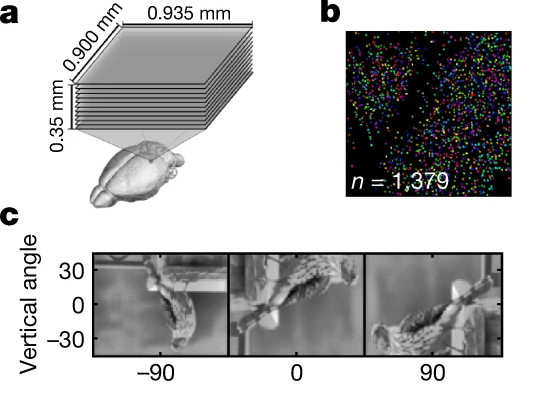

Armed with this large dataset, they set out to develop a method that
could reliably estimate the covariance structure of these neural
responses: *cross-validated PCA*.

Since most neuroscience experiments collect multiple responses to the
same stimulus across different trials, Stringer et al. (2019) decided to
use one set of responses as a training set and other as a test set when
computing the covariance eigenspectrum.

Specifically, if there were $N$ unique stimuli – each seen twice – the
data matrix $X \in \mathbb{R}^{2N \times P}$ is split into two matrices
$X_\text{train} \in \mathbb{R}^{N \times P}$ and
$X_\text{test} \in \mathbb{R}^{N \times P}$, where the rows of
$X_\text{train}$ and $X_\text{test}$ correspond to the same stimuli.



### Step 1 – Compute eigenvectors on the training set

The first step is to compute the principal components – the eigenvectors
of the covariance matrix – of the training set:

<span class="column-margin">As usual, $X_\text{train}$ must be centered
when computing its covariance.</span>

$$
\begin{align*}
    \text{cov}(X_\text{train}, X_\text{train})
    &= X_\text{train}^\top X_\text{train} / (n - 1)\\
    &= V \Lambda V^\top
\end{align*}
$$



### Step 2 – Compute cross-validated eigenvalues

The second step is to compute *cross-validated eigenvalues* by
projecting both the training and the test sets onto the eigenvectors
from Step 1, and computing their cross-covariance:

<span class="column-margin">Both $X_\text{train}$ and $X_\text{test}$
are centered prior to the projection using the mean of
$X_\text{train}.$</span>

$$
\begin{align*}
    \Lambda_\text{cross-validated}
    &= \text{cov}(X_\text{train}V, X_\text{test}V)\\
    &= \left( X_\text{train} V \right) ^\top \left( X_\text{test} V \right) / (n - 1)
\end{align*}
$$



These cross-validated eigenvalues represent the covariance reliably
shared across two presentations of the visual stimulus – the “stable”
part of the visual representation of a natural image.

> **Warning**
>
> These cross-validated “eigenvalues” need not be positive: if there is
> no shared covariance between the two systems along a particular
> eigenvector, the expected value of the eigenvalue is $0$. This makes
> interpretation simple: if there is reliable variance along a
> dimension, its cross-validated eigenvalue will be significantly above
> zero.

### A computational recipe

In [ ]:
class CrossValidatedPCA:
    def __init__(self) -> None:
        return

    def __call__(self, /, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.pca = PCA()
        self.pca.fit(x)
        x_transformed = self.pca.transform(x)
        y_transformed = self.pca.transform(y)

        cross_covariance = np.cov(
            x_transformed,
            y_transformed,
            rowvar=False,
        )

        self.cross_validated_spectrum = np.diag(
            cross_covariance[: self.pca.n_components_, self.pca.n_components_ :]
        )


## Investigating neural data

Let’s apply cross-validated PCA to our fMRI data to see what it looks
like!

In [ ]:
data = load_dataset(subject=0, roi="general").load()

display(data)


Note that the data contain fMRI responses to two repetitions of
$N = 700$ images for a total of $2N = 1400$ presentations.

In [ ]:
data_repetition_1 = data.isel({"presentation": data["rep_id"] == 0}).sortby(
    "stimulus_id"
)
data_repetition_2 = data.isel({"presentation": data["rep_id"] == 1}).sortby(
    "stimulus_id"
)

cv_pca = CrossValidatedPCA()
cv_pca(data_repetition_1.values, data_repetition_2.values)


In [ ]:
def plot_cross_validated_spectrum(
    cv_pca: CrossValidatedPCA,
    *,
    log: bool = False,
    original: bool = False,
    square: bool = False,
    bin_logarithmically: bool = False,
) -> Figure:
    fig, ax = plt.subplots()

    data = pd.DataFrame(
        {
            "rank": 1 + np.arange(len(cv_pca.cross_validated_spectrum) - 1),
            "cross-validated": cv_pca.cross_validated_spectrum[:-1],
            "original": cv_pca.pca.explained_variance_[:-1],
        }
    ).melt(
        id_vars=["rank"],
        value_vars=["cross-validated", "original"],
        value_name="eigenvalue",
        var_name="spectrum",
    )

    if original:
        sns.lineplot(
            ax=ax,
            data=data,
            x="rank",
            y="eigenvalue",
            hue="spectrum",
        )
    else:
        data = (
            data.loc[data["spectrum"] == "cross-validated"]
            .rename(columns={"eigenvalue": "cross-validated eigenvalue"})
            .drop(columns="spectrum")
        )

        if bin_logarithmically:
            data["rank"] = assign_logarithmic_bins(
                data["rank"], points_per_bin=5, min_=1, max_=10_000
            )

            sns.lineplot(
                ax=ax,
                data=data,
                x="rank",
                y="cross-validated eigenvalue",
                marker="o",
                dashes=False,
                ls="None",
                err_style="bars",
                estimator="mean",
                errorbar="sd",
            )
        else:
            sns.lineplot(
                ax=ax,
                data=data,
                x="rank",
                y="cross-validated eigenvalue",
            )

    if log:
        ax.axhline(0, ls="--", c="gray")
        ax.set_xlim(left=1)
        ax.set_ylim(bottom=1e-2)
        ax.set_xscale("log")
        ax.set_yscale("log")

        if square:
            ax.axis("square")

    sns.despine(ax=ax, offset=20)
    plt.close(fig)

    return fig


plot_cross_validated_spectrum(cv_pca)


We can see a typical spectrum that appears to have a knee somewhere
around 10 dimensions, beyond which the variance quickly flattens out
close to zero.

Let’s re-plot this cross-validated covariance eigenspectrum on a
logarithmic scale.

In [ ]:
plot_cross_validated_spectrum(cv_pca, log=True)


Here, we see that the apparent knee isn’t present – in fact, the
spectrum appears to obey a power law at all ranks! Additionally, since
these eigenvalues were obtained from a cross-validated analysis, we know
that they represent stimulus-related variance that is consistent across
different presentations of the same stimuli and not noise.

To verify this, let’s plot the covariance spectrum of the training
dataset, the one that we would obtain from regular principal components
analysis.

In [ ]:
plot_cross_validated_spectrum(cv_pca, log=True, original=True)


The covariance eigenspectrum of the training data (orange) is higher
than the cross-validated spectrum (blue) at all ranks – suggesting that
the process is indeed removing trial-specific noise.

> **The neural population code is high-dimensional!**
>
> Importantly, note that after removing trial-specific noise using
> cross-validated PCA, the covariance eigenspectrum retains its
> power-law structure at all ranks! This suggests that the neural
> population code is truly high-dimensional.

Finally, let’s re-plot the cross-validated spectrum in a cleaner
fashion, where the trends of interest are more clearly visible.

In [ ]:
with sns.axes_style("whitegrid"):
    fig = plot_cross_validated_spectrum(
        cv_pca, log=True, bin_logarithmically=True, square=True
    )
    ax = fig.get_axes()[0]
    ax.grid(True, which="minor", c="whitesmoke")
    ax.grid(True, which="major", c="lightgray")
    for loc in ("left", "bottom"):
        ax.spines[loc].set_visible(False)
    display(fig)


Here, we’ve averaged the spectrum in local bins that expand
exponentially in size (and thus appear uniformly spaced on the
logarithmic scale). The individual points denote the mean
cross-validated eigenvalue in each bin while the error bars denote the
standard deviation of these eigenvalues.

Averaging within such bins allows us to detect signal even in a regime
where the cross-validated spectrum oscillates wildly near zero and also
visualize the power law more cleanly.

> **The power law extends further with more data!**
>
> Note that the power-law scaling doesn’t saturate at the tail of the
> spectrum, suggesting that with even larger datasets with more stimuli,
> we might find reliable stimulus-specific variance along even more
> dimensions! In fact, if we use a larger version of this dataset –
> including all 10,000 images seen by a single participant – we do
> indeed see continued power law scaling.

## A universal power-law exponent

The power-law exponent of the neural data appears very close to $-1$, as
you can see from the slope of the cross-validated spectrum
Interestingly, a power-law exponent of $-1$ appears with surprising
regularity in neuroscience.

> **What makes $\text{variance} \propto \text{rank}^{-1}$ special?**
>
> A power-law index of $-1$ implies a special sort of scale-invariance.
> Consider the total variance captured by such a covariance
> eigenspectrum within a range of ranks $[\alpha, \beta]$:
>
> $$
> \begin{align*}
>     \int_\alpha^\beta x^{-1} dx &= \ln{\left\lvert\frac{\beta}{\alpha}\right\rvert}
> \end{align*}
> $$
>
> This total variance only depends on the ratio $\beta / \alpha$ –
> indicating that a power law with a $-1$ slope has equal variance in
> each decade: i.e., the total variance from rank $1$ to rank $10$ is
> equal to the total variance from rank $100$ to rank $1000$.
>
> This suggests that each decade is equally important and contributes as
> much to the representation, though the later decades have their
> variance spread out over many more dimensions.

> **An optimality criterion for population codes?**
>
> Stringer et al. (2019) provide a possible explanation for why systems
> might tend toward a $-1$ covariance eigenspectrum.
>
> For sufficiently high-dimensional data, if a spectrum decays any
> slower than $-1$, the representational manifold becomes non-smooth:
> small changes in the input might lead to large changes in the
> representational space – clearly an undesirable property for stable
> perception and cognition.
>
> In contrast, if a spectrum decays significantly faster than $-1$, it
> loses some expressivity by not utilizing all the dimensions it has
> available.

### Mouse primary visual cortex

Stringer et al. (2019), who developed cross-validated PCA, discovered
that mouse primary visual cortex responses obey a power-law with
exponent $-1$ over several orders of magnitude.

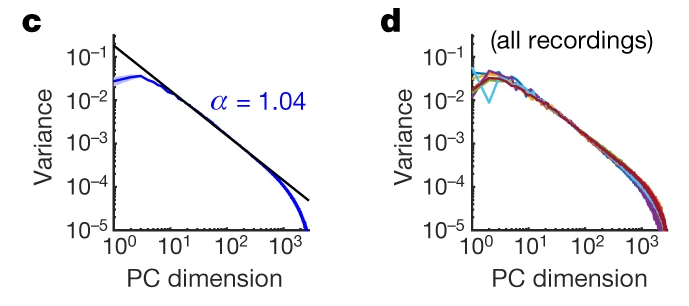

### Zebrafish brain

More recently, Wang et al. (2023) reported a similar result from
whole-brain calcium recordings in zebrafish during hunting and
spontaneous behavior.

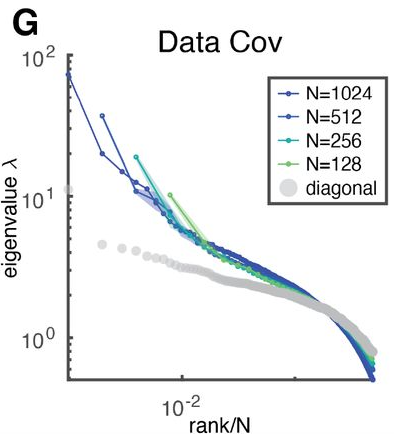

### Deep neural networks

Interestingly, several recent results from the machine learning
literature also corroborate this result!

Specifically, Agrawal et al. (2022) report that neural networks whose
internal representations have a covariance spectrum that decays as a
power law with index $-1$ perform better. This has made the power law
index a statistic of interest for assessing model representation quality
– and perhaps a target of direct optimization.

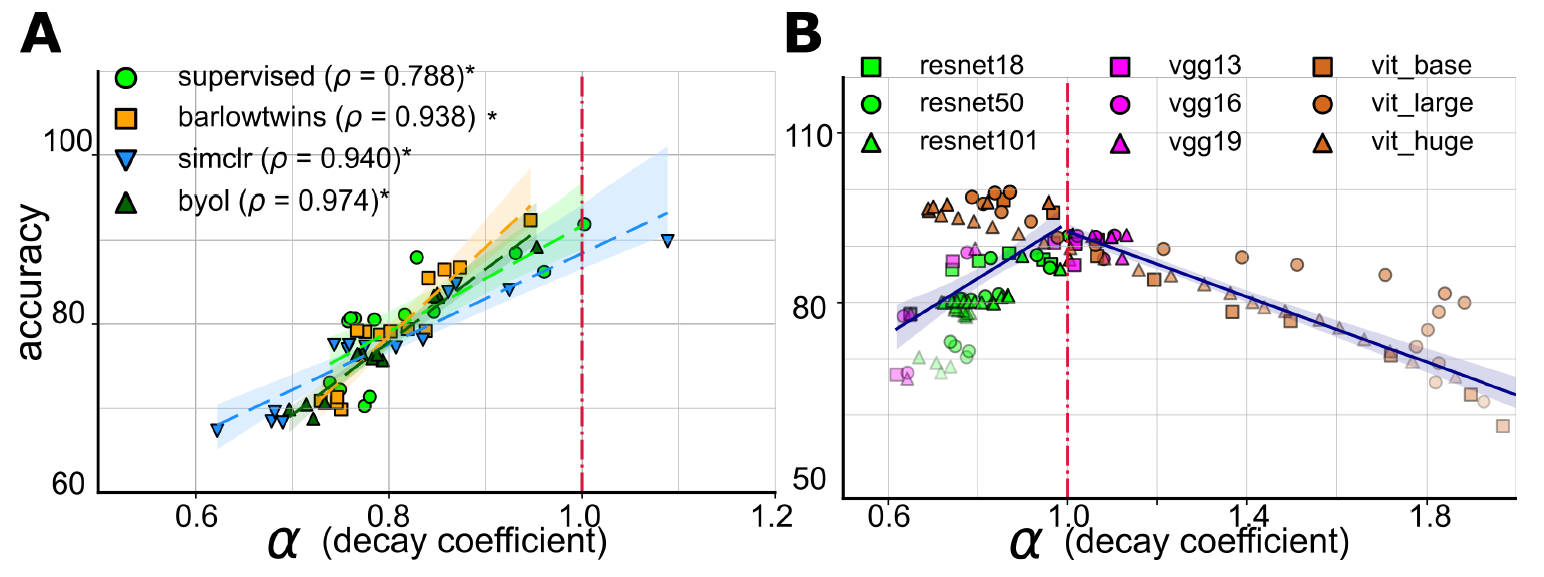

In addition, Kong et al. (2022) demonstrated that more adversarially
robust neural networks are a better match for macaque V1 eigenspectra.

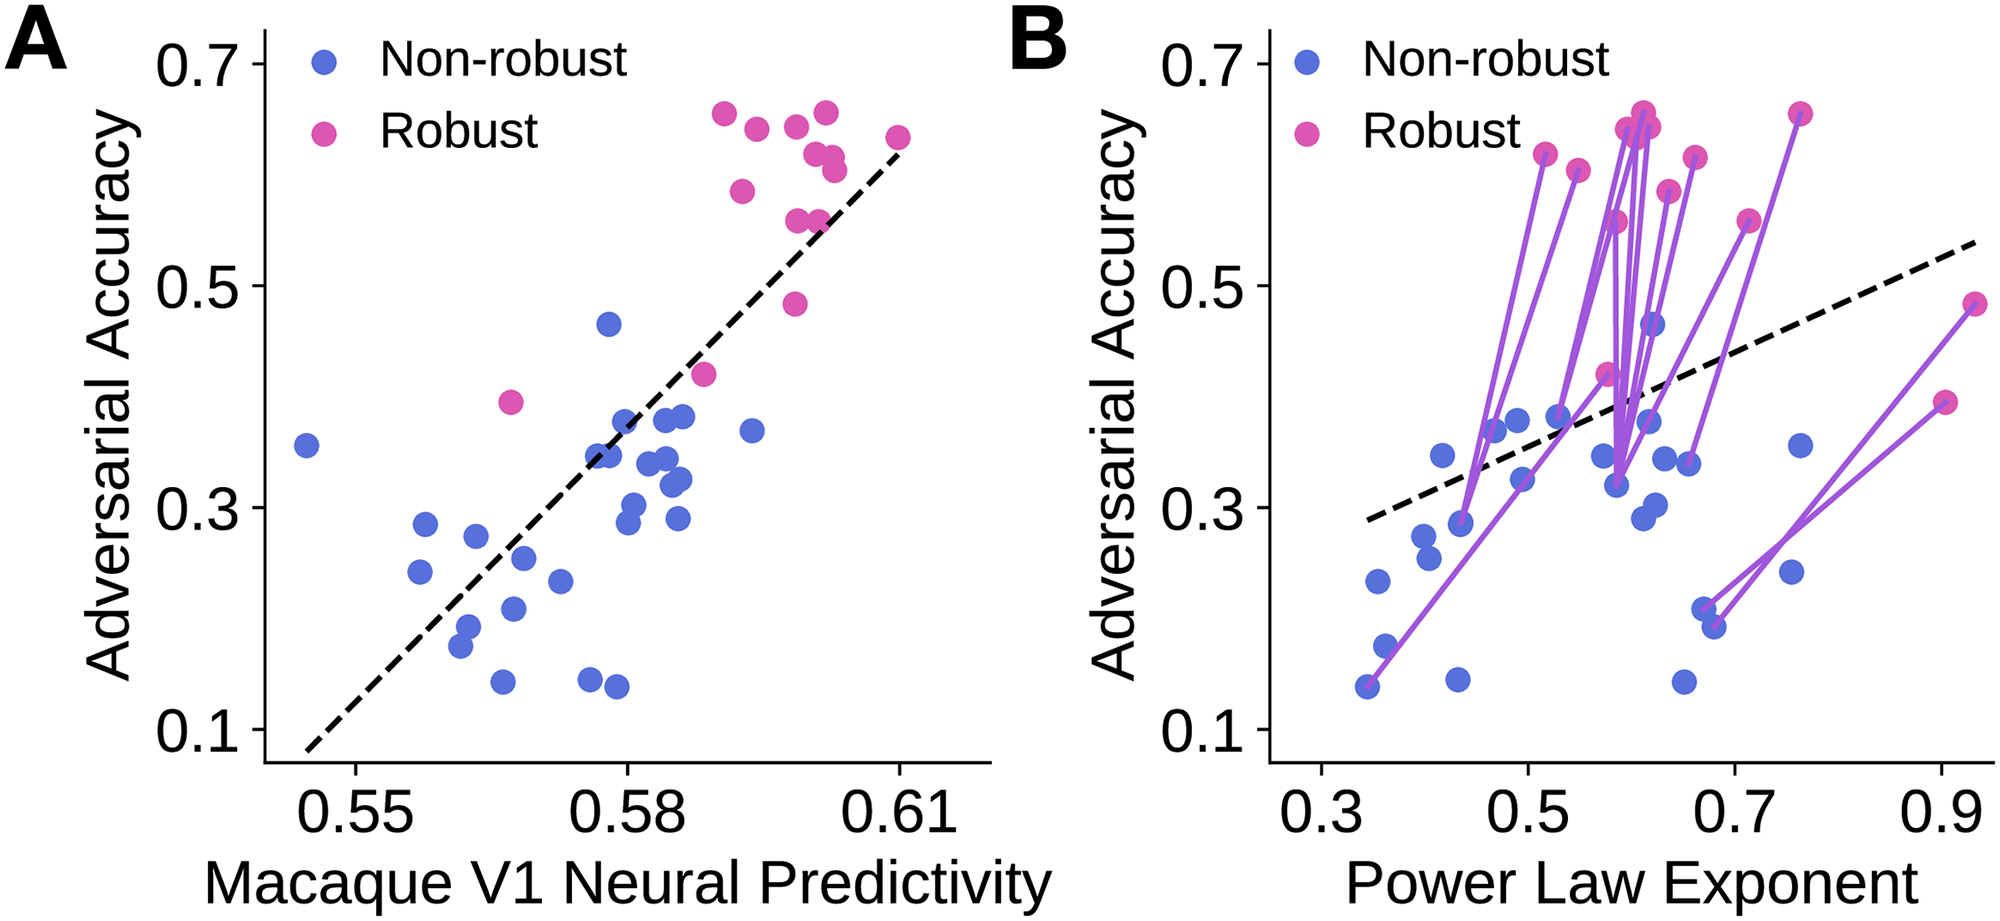

### Human visual cortex!

In this notebook, we have demonstrated that a similar scale-invariant
covariance structure underlies human visual representations of natural
scenes too!

In [ ]:
with sns.axes_style("whitegrid"):
    display(fig)


## Summary

In this notebook, we described a cross-validated approach to isolate
stimulus-specific variance and used it to demonstrate the
high-dimensional latent structure of neural population responses.
Understanding such a high-dimensional code must involve studying
reliable information along *all* dimensions.

> **Is the power-law exponent of -1 universal? Check your data!**
>
> Do we observe the same power-law covariance spectra in other
> organisms? Could it be a universal statistical property of neural
> population codes? Do all sensory systems use a high-dimensional
> population code – where an expressive representation of the outside
> world might allow rapid learning and generalization to various
> ethological tasks? Perhaps more *cognitive* systems might use
> low-dimensional representational formats to enhance robustness and
> invariance to irrelevant features.

Agrawal, Kumar K, Arnab Kumar Mondal, Arna Ghosh, and Blake Richards.
2022. “\Alpha-ReQ : Assessing Representation Quality in Self-Supervised
Learning by Measuring Eigenspectrum Decay.” In *Advances in Neural
Information Processing Systems*, edited by S. Koyejo, S. Mohamed, A.
Agarwal, D. Belgrave, K. Cho, and A. Oh, 35:17626–38. Curran Associates,
Inc.
<https://proceedings.neurips.cc/paper_files/paper/2022/file/70596d70542c51c8d9b4e423f4bf2736-Paper-Conference.pdf>.

Kong, Nathan C. L., Eshed Margalit, Justin L. Gardner, and Anthony M.
Norcia. 2022. “Increasing Neural Network Robustness Improves Match to
Macaque V1 Eigenspectrum, Spatial Frequency Preference and
Predictivity.” Edited by Peter E. Latham. *PLOS Computational Biology*
18 (1): e1009739. <https://doi.org/10.1371/journal.pcbi.1009739>.

Stringer, Carsen, Marius Pachitariu, Nicholas Steinmetz, Matteo
Carandini, and Kenneth D. Harris. 2019. “High-Dimensional Geometry of
Population Responses in Visual Cortex.” *Nature* 571 (7765): 361–65.
<https://doi.org/10.1038/s41586-019-1346-5>.

Wang, Zezhen, Weihao Mai, Yuming Chai, Kexin Qi, Hongtai Ren, Chen Shen,
Shiwu Zhang, Guodong Tan, Yu Hu, and Quan Wen. 2023. “The
Scale-Invariant Covariance Spectrum of Brain-Wide Activity,” February.
<https://doi.org/10.1101/2023.02.23.529673>.